<a href="https://colab.research.google.com/github/royg27/Machine-Learning/blob/master/GAN_roy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setting up

In [1]:
from keras.optimizers import Adam
import numpy as np

np.random.seed(10)

noise_dim = 100



batch_size = 16
steps_per_epoch = 3750  # batch_size * steps_per_epoch = epoch size (train size)
epochs = 5

img_rows, img_cols, channels = 28, 28, 1
sparse_dim = img_rows * img_cols * channels

optimizer = Adam(0.0005, 0.5) 
#optimizer = Adam(0.001)

Using TensorFlow backend.


import data set

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normalize between +1 -1

x_train = x_train.reshape(-1, img_rows*img_cols*channels) # each image as vector
x_test = x_test.reshape(-1, img_rows*img_cols*channels) # each image as vector


np.random.shuffle(x_train)
print(x_train.shape)

11493376/11490434 [==============================] - 2s 0us/step
(60000, 784)


creating gan:

In [0]:
# generator:
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, AveragePooling2D, MaxPooling2D, BatchNormalization

# input: image size
# output: noise size
def create_reconstructor():
    reconstructor = Sequential()

    reconstructor.add(Dense(512, input_dim=img_cols*img_rows*channels))
    reconstructor.add(LeakyReLU(0.2))

    reconstructor.add(Dense(256))
    reconstructor.add(LeakyReLU(0.2))

    reconstructor.add(Dense(noise_dim))
    reconstructor.add(LeakyReLU(0.2))

    #reconstructor.compile(loss='mean_squared_error', optimizer='sgd')
    return reconstructor

# input: noise size
# output: image size
def create_generator():
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    # remove this to return to FC scheme
    generator.add(Reshape((img_rows, img_cols, channels)))
    #generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

# input: image size
# output: 1 number - 1 real 0 fake
# descriminator:
def create_descriminator():
    discriminator = Sequential()
    #16 - better
    discriminator.add(Conv2D(16, (3, 3), strides=(2,2),padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    #32 - better
    discriminator.add(Conv2D(32, (3, 3), strides=(2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    # 64 - better
    discriminator.add(Conv2D(64, (3, 3), strides=(2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid'))   # 1 number which indicates real / fake
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator
    
"""
def create_descriminator():
    discriminator = Sequential()
     
    discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator
"""
# build GAN
discriminator = create_descriminator()
generator = create_generator()
reconstructor = create_reconstructor()

discriminator.trainable = False   # will be trained separately, not as GAN

gan_input = Input(shape=(noise_dim,))

fake_image = generator(gan_input)

fake_image_vec = Flatten()(fake_image)  # will enter reconstructor


gan_output = discriminator(fake_image)

vae_output = reconstructor(fake_image_vec)

vae = Model(gan_input, vae_output)
vae.compile(loss='mean_squared_error', optimizer='sgd') #todo: consider MAE


gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


train the GAN:

(None, 784)
(None, 100)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0 	 Discriminator Loss: 0.24623315036296844 		 Generator Loss: 3.267835855484009 		 Reconstructor Loss: 0.9457851648330688 
Epoch: 1 	 Discriminator Loss: 0.2589292526245117 		 Generator Loss: 3.885723829269409 		 Reconstructor Loss: 0.9594258069992065 
Epoch: 2 	 Discriminator Loss: 0.23936159908771515 		 Generator Loss: 3.946578025817871 		 Reconstructor Loss: 1.0347537994384766 
Epoch: 3 	 Discriminator Loss: 0.21601106226444244 		 Generator Loss: 5.366122722625732 		 Reconstructor Loss: 1.0479507446289062 
Epoch: 4 	 Discriminator Loss: 0.26192808151245117 		 Generator Loss: 4.450636386871338 		 Reconstructor Loss: 1.0151227712631226 
Epoch: 5 	 Discriminator Loss: 0.2654881477355957 		 Generator Loss: 3.3728604316711426 		 Reconstructor Loss: 0.9949914216995239 
Epoch: 6 	 Discriminator Loss: 0.21870771050453186 		 Generator Loss: 3.5679547786712646 		 Reconstructor Loss: 1.0137231349945068 
Epoch: 7 	 Discriminator Loss: 0.33633220195770264 		 Generator Loss: 4.90957164764

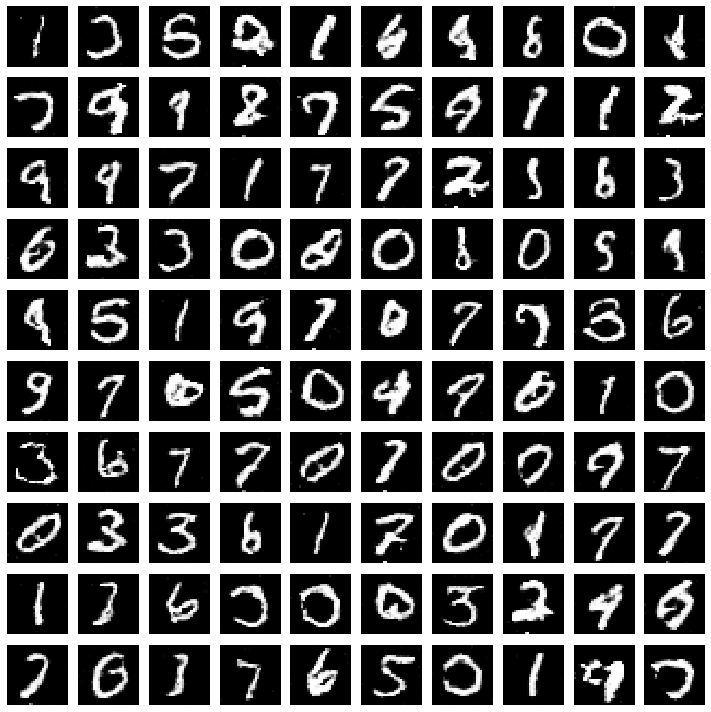

In [0]:
import matplotlib.pyplot as plt


for epoch in range(epochs):  
    for batch in range(steps_per_epoch): 
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        fake_x = generator.predict(noise) # create G(z)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)] # sample real image
        #remove below to return to FC scheme
        real_x = real_x.reshape(fake_x.shape)

        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        # train_on_batch recieves data and desired output
        d_loss_fake = discriminator.train_on_batch(x[:batch_size], disc_y[:batch_size])
        d_loss_real = discriminator.train_on_batch(x[batch_size:-1], disc_y[batch_size:-1])
        # train GAN (descriminator weights are fixed)
        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)
        # train reconstructor
        if(batch)
          r_loss = vae.train_on_batch(noise[:batch_size],noise[:batch_size])

        

    print(f'Epoch: {epoch} \t Discriminator Loss: {(d_loss_fake+d_loss_real)/2} \t\t Generator Loss: {g_loss} \t\t Reconstructor Loss: {r_loss} ')


def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)





Train sparse dictionary: *RUN ONLY ONCE*

In [0]:
from sklearn.decomposition import DictionaryLearning
from numpy import loadtxt,savetxt
import matplotlib.pyplot as plt
from google.colab import files


# init a dictionary learning alg - based on LARS
# TODO - change to all data set and make redundant dictionary
d=DictionaryLearning(n_components=sparse_dim)
# train dictionary
d.fit(x_train)
dictionary = d.components_
savetxt('dictionary.csv', dictionary, delimiter=',')
# download to local machine
files.download('dictionary.csv') 

# we will download to a local file named dictionary_loaded
#*reconstruct* an image for sanity check
representation_vec = d.transform(x_train[1:2,:])
print(representation_vec.shape)
print(dictionary_loaded2.shape)
dictionary_loaded2 = np.transpose(dictionary_loaded2)
representation_vec = np.transpose(representation_vec)
ans = np.matmul(dictionary_loaded2,representation_vec)

plt.figure()
plt.imshow(ans.reshape((img_rows, img_cols)), cmap='gray')

plt.figure()
real_im = x_train[1:2,:]
plt.imshow(real_im.reshape((img_rows, img_cols)), cmap='gray')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-f8731d9080ba>", line 11, in <module>
    d.fit(x_train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_dict_learning.py", line 1238, in fit
    positive_code=self.positive_code)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_dict_learning.py", line 551, in dict_learning
    code, S, dictionary = linalg.svd(X, full_matrices=False)
  File "/usr/local/lib/python3.6/dist-packages/scipy/linalg/decomp_svd.py", line 129, in svd
    full_matrices=full_matrices, overwrite_a=overwrite_a)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._re

KeyboardInterrupt: ignored

reload trained dictionary from local machine - dictionary_loaded.csv

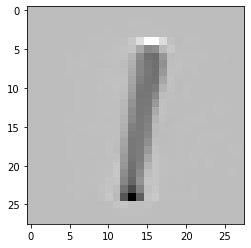

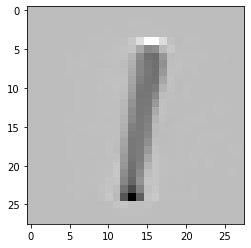

In [3]:
from numpy import loadtxt,savetxt
import matplotlib.pyplot as plt

dictionary_loaded2 = loadtxt('dictionary_loaded.csv', delimiter=',')
dictionary_loaded2 = np.array(dictionary_loaded2,dtype=np.float32) # format that is used in keras
# the above dict should enable training a regular gan

# sanity check
dictionary_loaded2 = np.transpose(dictionary_loaded2)
atom1 = (dictionary_loaded2)[:,0]
plt.figure()
plt.imshow(atom1.reshape((img_rows, img_cols)), cmap='gray')

first_atom = np.zeros(784)
first_atom[0] = 1
plt.figure()
ans = np.matmul(dictionary_loaded2,np.transpose(first_atom))
plt.imshow(ans.reshape((img_rows, img_cols)), cmap='gray')

Sanity test on dictionary

[ 0.03436248  0.03436248  0.03436248  0.03436248  0.03436248  0.03436248
  0.03436248  0.03436248  0.03436248  0.03436248  0.03436248  0.03436248
  0.03436126  0.03435722  0.03435959  0.03436236  0.03436248  0.03436248
  0.03436248  0.03436248  0.03436248  0.03436248  0.03436248  0.03436248
  0.03436248  0.03436248  0.03436248  0.03436248  0.03436248  0.03436248
  0.03436248  0.03436248  0.03436244  0.03436235  0.03436194  0.0343608
  0.03436666  0.03437388  0.03437438  0.03436788  0.03435844  0.03435289
  0.03437248  0.03442568  0.03441432  0.03436488  0.03437235  0.0343735
  0.03436887  0.03436092  0.03436141  0.03436195  0.03436248  0.03436248
  0.03436248  0.03436248  0.03436248  0.03436248  0.03436251  0.03436249
  0.03436416  0.03436303  0.03435951  0.03435313  0.03436487  0.03439062
  0.03442306  0.03442932  0.0344498   0.03449983  0.03450623  0.0345155
  0.03438831  0.03426142  0.03420307  0.03424123  0.0343274   0.03439284
  0.03437362  0.03435237  0.03436042  0.03436374  0.03

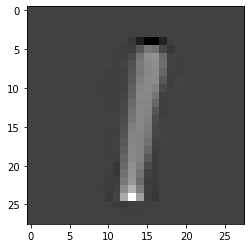

In [0]:
from sklearn.decomposition import DictionaryLearning

print(dictionary_loaded2[:,0] )

atom1 = (dictionary_loaded2)[:,0]
plt.figure()
plt.imshow(atom1.reshape((img_rows, img_cols)), cmap='gray')




In [0]:
L1_weight = 10   # Loss = data_fidelity + L1_weight * L1_norm
thr_value = 0.1

Trying to Create pursuit network for sanity check
Input : Image
Output: Image_r = D*Sparse

In [0]:
# with pursuit and thresholding approach
# generator:
from keras.utils import plot_model
from keras.models import Sequential
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomNormal, glorot_uniform
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, AveragePooling2D, MaxPooling2D, BatchNormalization, Lambda, ReLU, ThresholdedReLU, Activation
from tensorflow.linalg import matmul, matrix_transpose
from tensorflow.math import abs
from keras import regularizers


from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from tensorflow import cast

# would cause small entries in absulute values to be set to zero and will create sparse vectors
def soft_threshlding(x):
  above_thr_pos = x * cast(x >= thr_value, tf.float32)
  below_thr_neg = x * cast(x <= -thr_value, tf.float32)
  return (above_thr_pos + below_thr_neg)

get_custom_objects().update({'soft_threshlding': Activation(soft_threshlding)})

def create_pursuiter():
    pursuiter = Sequential()
    init = RandomNormal(0,stddev=0.02)
    pursuiter.add(Dense(1024, kernel_initializer=init, input_dim=784,name="pursuiter_input"))
    pursuiter.add(BatchNormalization())
    pursuiter.add(LeakyReLU(0.2))

    pursuiter.add(Dense(1024,kernel_initializer=init,name="pursuiter_2nd"))
    pursuiter.add(BatchNormalization())
    pursuiter.add(LeakyReLU(0.2))

    pursuiter.add(Dense(sparse_dim, kernel_initializer=init,name="pursuiter_3rd"))
    pursuiter.add(BatchNormalization())
    # soft thresholding activation
    pursuiter.add(Activation(soft_threshlding, name='soft_threshlding'))

    #pursuiter.add(Lambda(lambda x: matrix_transpose(matmul(dictionary_loaded2,matrix_transpose(x))),name='mul_in_D'))

    #pursuiter.compile(loss='mean_squared_error', optimizer=optimizer)
    return pursuiter

pursuiter = create_pursuiter()
pursuiter.name = "pursuit_unit"
pursuiter_input = Input(shape=(784,))

sparse_vec = pursuiter(pursuiter_input) 

# a layer that creates the multiplication between the sparse tensor with dictionary to create image
fake_image_vec = Lambda(lambda x: matrix_transpose(matmul(dictionary_loaded2,matrix_transpose(x))),name='mul_in_D')(sparse_vec)


#pursuiter_full = Model(pursuiter_input, [fake_image_vec,sparse_vec])
#pursuiter_full.compile(loss=['mean_squared_error','mean_absolute_error'], optimizer=optimizer,loss_weights=[1,0])
pursuiter_full = Model(pursuiter_input, fake_image_vec)
pursuiter_full.compile(loss='mean_squared_error', optimizer=optimizer)
pursuiter_full.name = "pursuiter_full"

print(pursuiter_full.summary())
zeros = np.zeros(10000*784)
zeros=zeros.reshape(10000,784)
#model1=pursuiter_full.fit(x_train, [x_train,x_train], validation_data=(x_test, [x_test,zeros]), epochs=epochs, batch_size=16)
model1=pursuiter_full.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=10, batch_size=16)

plot_model(pursuiter_full, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

plot_model(pursuiter, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Model: "pursuiter_full"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 784)               0         
_________________________________________________________________
pursuit_unit (Sequential)    (None, 784)               2668368   
_________________________________________________________________
mul_in_D (Lambda)            (None, 784)               0         
Total params: 2,668,368
Trainable params: 2,662,704
Non-trainable params: 5,664
_________________________________________________________________
None
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 36s 600us/step - loss: 0.2377 - val_loss: 1676.1844
Epoch 2/10
60000/60000 [==============================] - 32s 534us/step - loss: 0.0782 - val_loss: 1207.9882
Epoch 3/10
50416/60000 [========================>.....] - ETA: 4s - loss: 0.0647

{'val_loss': [1684.7371626953125, 913.1123381835938, 1002.3588461914062, 843.9326375976563, 894.4054498046875, 1029.3403288085938, 990.5882129882813, 1007.5419294921875, 1054.5893450195313, 1112.1804073242188], 'loss': [0.26607393118739125, 0.08156835175454616, 0.06499877068698406, 0.058239109587669376, 0.05403695854942004, 0.05145916385650635, 0.04976319066683451, 0.048136981893579164, 0.0471495400339365, 0.04572537525395552]}


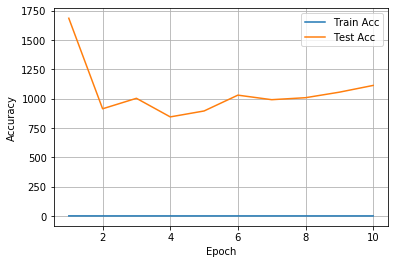

In [0]:
plt.figure()
print(model1.history)
plt.plot(range(1,len(model1.history['loss'])+1),model1.history['loss'], label='Train Acc')
plt.plot(range(1,len(model1.history['val_loss'])+1),model1.history['val_loss'], label='Test Acc')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid()
plt.show()

average support on train=  641.4687666666666
average support on test=  782.9436
Im_r, Im
sparse vector dim =  (1, 784)
sparse vector non zeros =  781
sparse vec max element is =  304.58716
positive number =  414
sparse vec average positive = 36.376102
negatives number =  367
sparse vec average negative = -36.284073


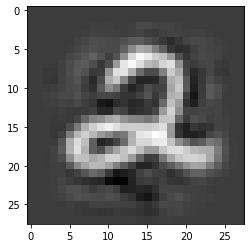

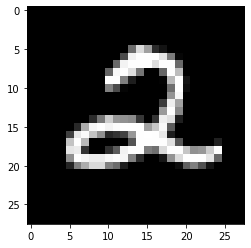

In [0]:
import random

x_train_pred = pursuiter.predict(x_train)
print("average support on train= ", np.count_nonzero(x_train_pred)/60000)

x_test_pred = pursuiter.predict(x_test)
print("average support on test= ", np.count_nonzero(x_test_pred)/10000)

im = random.randrange(0, 9999)
x_train.shape
x = np.array([x_test[im,:]])

# plt results
print("Im_r, Im")
plt.figure()
plt.imshow(pursuiter_full.predict(x)[0].reshape((img_rows, img_cols)), cmap='gray')

plt.figure()
plt.imshow(x[0].reshape((img_rows, img_cols)), cmap='gray')

# is it sparse?
pred = pursuiter.predict(x)
print("sparse vector dim = ", pred.shape)
print("sparse vector non zeros = ", np.count_nonzero(pred))
print("sparse vec max element is = ",np.max(pred))
print("positive number = ", np.count_nonzero(pred[pred>0]))
print("sparse vec average positive =",np.mean(pred[pred>0]))
print("negatives number = ", np.count_nonzero(pred[pred<0]))
print("sparse vec average negative =",np.mean(pred[pred<0]))


GAN + Reconstructor

Model: "Gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
init (Dense)                 (None, 256)               25856     
_________________________________________________________________
BN1 (BatchNormalization)     (None, 256)               1024      
_________________________________________________________________
Activation1 (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
hidden1 (Dense)              (None, 512)               131584    
_________________________________________________________________
BN2 (BatchNormalization)     (None, 512)               2048      
_________________________________________________________________
Activation2 (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 1024)              525312  

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


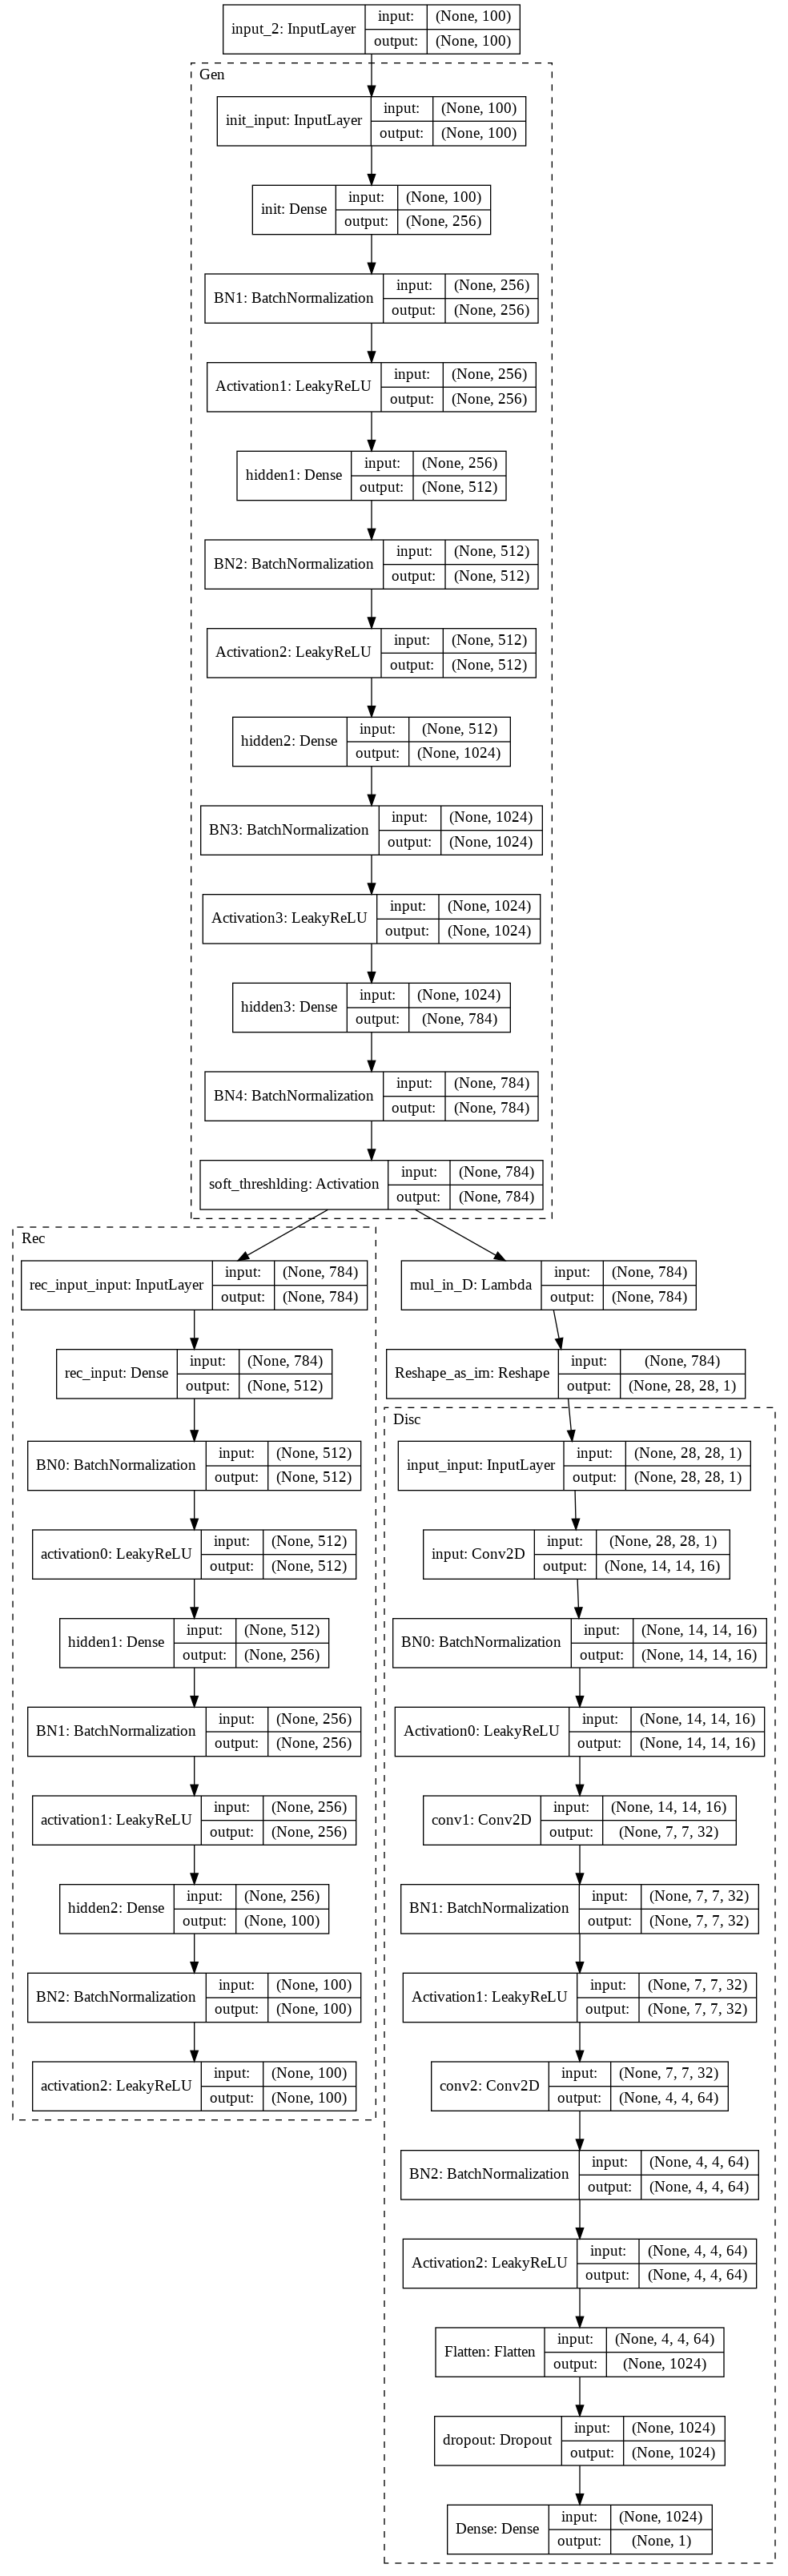

In [8]:
# with pursuit and thresholding approach
# generator:
from keras.utils import plot_model
from keras.models import Sequential
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomNormal, glorot_uniform
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, AveragePooling2D, MaxPooling2D, BatchNormalization, Lambda, ReLU, ThresholdedReLU, Activation
from tensorflow.linalg import matmul, matrix_transpose
from tensorflow.math import abs
from keras import regularizers
from keras.losses import kullback_leibler_divergence, binary_crossentropy


from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from tensorflow import cast

# costum loss - symmetric KL divergence

def my_loss(y_actual,y_pred):
  return kullback_leibler_divergence(y_actual,y_pred)
  #return 0.5*(kullback_leibler_divergence(y_actual,y_pred) + binary_crossentropy(y_actual,y_pred))


# would cause small entries in absulute values to be set to zero and will create sparse vectors
def soft_threshlding(x):
  above_thr_pos = x * cast(x >= thr_value, tf.float32)
  below_thr_neg = x * cast(x <= -thr_value, tf.float32)
  return (above_thr_pos + below_thr_neg)

get_custom_objects().update({'soft_threshlding': Activation(soft_threshlding)})

# input: sparse vec size
# output: noise size
def create_reconstructor():
    reconstructor = Sequential()
    init = RandomNormal(0,stddev=0.02)

    reconstructor.add(Dense(512,  kernel_initializer=init, input_dim=sparse_dim,name="rec_input"))
    reconstructor.add(BatchNormalization(name="BN0"))
    reconstructor.add(LeakyReLU(0.2,name="activation0"))

    reconstructor.add(Dense(256, kernel_initializer=init,name="hidden1"))
    reconstructor.add(BatchNormalization(name="BN1"))
    reconstructor.add(LeakyReLU(0.2,name="activation1"))

    reconstructor.add(Dense(noise_dim, kernel_initializer=init,name="hidden2"))
    reconstructor.add(BatchNormalization(name="BN2"))
    reconstructor.add(LeakyReLU(0.2,name="activation2"))

    #reconstructor.compile(loss='mean_squared_error', optimizer='sgd')
    return reconstructor

# input: noise size
# output: sparse vec size
def create_generator():
    generator = Sequential()
    init = RandomNormal(0,stddev=0.02)
    generator.add(Dense(256, kernel_initializer=init, input_dim=noise_dim,name="init"))
    generator.add(BatchNormalization(name="BN1"))
    generator.add(LeakyReLU(0.2,name="Activation1"))

    generator.add(Dense(512,kernel_initializer=init,name="hidden1"))
    generator.add(BatchNormalization(name="BN2"))
    generator.add(LeakyReLU(0.2,name="Activation2"))

    generator.add(Dense(1024,kernel_initializer=init,name="hidden2"))
    generator.add(BatchNormalization(name="BN3"))
    generator.add(LeakyReLU(0.2,name="Activation3"))

    generator.add(Dense(sparse_dim, kernel_initializer=init,name="hidden3"))
    # soft thresholding activation
    generator.add(BatchNormalization(name="BN4"))
    generator.add(Activation(soft_threshlding, name='soft_threshlding'))
    return generator

# input: image size
# output: 1 number - 1 real 0 fake
# descriminator:
def create_descriminator():
    discriminator = Sequential()
    #16 - better
    discriminator.add(Conv2D(16, (3, 3), strides=(2,2),padding='same', kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels),name="input"))
    discriminator.add(BatchNormalization(name="BN0"))
    discriminator.add(LeakyReLU(0.2,name="Activation0"))
    #32 - better
    discriminator.add(Conv2D(32, (3, 3), strides=(2,2), padding='same',  kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="conv1"))
    discriminator.add(BatchNormalization(name="BN1"))
    discriminator.add(LeakyReLU(0.2,name="Activation1"))
    # 64 - better
    discriminator.add(Conv2D(64, (3, 3), strides=(2,2), padding='same',  kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="conv2"))
    discriminator.add(BatchNormalization(name="BN2"))
    discriminator.add(LeakyReLU(0.2,name="Activation2"))
    
    discriminator.add(Flatten(name="Flatten"))
    discriminator.add(Dropout(0.4,name="dropout"))
    discriminator.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="Dense"))   # 1 number which indicates real / fake
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

# build GAN
discriminator = create_descriminator()
generator = create_generator()
reconstructor = create_reconstructor()
# naming:
discriminator.name = "Disc"
generator.name = "Gen"
reconstructor.name = "Rec"
#
discriminator.trainable = False   # will be trained separately, not as GAN

gan_input = Input(shape=(noise_dim,))

# G(z) is a sparse vector
sparse_vec = generator(gan_input)   # sparse_dim size - it is thresholded

# a layer that creates the multiplication between the sparse tensor with dictionary to create image
fake_image_vec = Lambda(lambda x: matrix_transpose(matmul(dictionary_loaded2,matrix_transpose(x))),name='mul_in_D')(sparse_vec)
# reshape to image size - will be inserted to discriminator
fake_image = Reshape((img_rows, img_cols, channels),name="Reshape_as_im")(fake_image_vec)

gan_output = discriminator(fake_image)  # the descriminator output
vae_output = reconstructor(sparse_vec)  # the reconstructor output

vae = Model(gan_input, vae_output)
vae.compile(loss='mean_squared_error', optimizer='sgd')

# todo - double output double loss
gan = Model(gan_input, [gan_output,sparse_vec])
gan.compile(loss=[my_loss,'mean_absolute_error'], optimizer=optimizer,loss_weights=[1,L1_weight])

print(generator.summary())
print(discriminator.summary())
print(reconstructor.summary())
complete = Model(gan_input,[gan_output,vae_output])
plot_model(complete, to_file='model_plot.png', show_shapes=True, show_layer_names=True,expand_nested=True)


2nd approach train

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  0  loss =  0.5000895857810974  support =  0.0


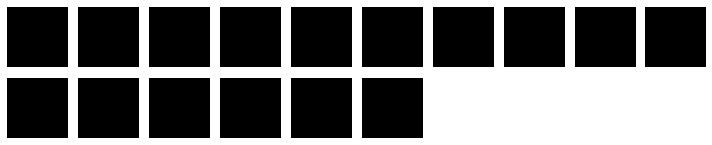

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


KeyboardInterrupt: ignored

In [7]:
import matplotlib.pyplot as plt

n_d = 1 # 1 10 100
n_g = 1  # 1 10 100
n_r = 1  # 1 10 100

def count_support(sparse_mat):
  return (np.count_nonzero(sparse_mat))/batch_size


def show_images(noise):
    generated_images = generator.predict(noise)
    generated_images = np.matmul(dictionary_loaded2,np.transpose(generated_images))
    generated_images = np.transpose(generated_images)
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

stop = False
fake_x = 0

def stop_criteria(fake_x):
  d_pred = np.sum(discriminator.predict(fake_x))/batch_size
  return d_pred >= 0.499

def d_ratio_on_fake(fake_x):
  return np.sum(discriminator.predict(fake_x))/batch_size

losses = np.array([])
iters= np.array([])

for epoch in range(10):  #epochs
    for iter in range(int(steps_per_epoch)):
      i = iter + int(epoch*(steps_per_epoch))
    # train D
      for batch in range(n_d):  #steps_per_epoch
          noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
          fake_x = generator.predict(noise) # create G(z)
          # fake is (batch_size,sparse_dim)
          
          fake_x = np.transpose(fake_x)
          # multiply by dict
          fake_x = np.matmul(dictionary_loaded2,fake_x)

          fake_x = np.transpose(fake_x)
          fake_x = fake_x.reshape(batch_size,img_rows,img_cols,channels)
          # fake_x is of size (batch,rows,cols,channels)

          real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)] # sample real image
          #remove below to return to FC scheme
          real_x = real_x.reshape(fake_x.shape)

          x = np.concatenate((real_x, fake_x))
          # x is of size (2*batch,rows,cols,channels)
          
          disc_y = np.zeros(2*batch_size)
          disc_y[:batch_size] = 0.9

          # train_on_batch recieves data and desired output
          d_loss_fake = discriminator.train_on_batch(x[:batch_size], disc_y[:batch_size])
          d_loss_real = discriminator.train_on_batch(x[batch_size:], disc_y[batch_size:])
          
          # check stop criteria
          if(epoch>0 and stop_criteria(x[:batch_size])):
            print("converged in epoch "+str(epoch))
            show_images(noise)
            stop = True
            break
      if(stop):
        break
      # print temp results
      if(i%1000==0):
        losses = np.append(losses,d_ratio_on_fake(fake_x))
        iters =  np.append(iters,i)
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        print("results after iter ",i," loss = ",d_ratio_on_fake(fake_x)," support = " ,count_support(generator.predict(noise)))
        show_images(noise)
      # train G
      for batch in range(n_g):  #steps_per_epoch
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        # train GAN (descriminator weights are fixed)
        y_gen_1 = np.ones(batch_size)
        y_gen_2 = np.zeros(batch_size * sparse_dim)
        y_gen_2 = y_gen_2.reshape(batch_size,sparse_dim)
        # TODO train the two outputs
        g_loss = gan.train_on_batch(noise, [y_gen_1,y_gen_2])
            
      # # train R
      # for batch in range(n_r):  #steps_per_epoch
      #   noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
      #   r_loss = vae.train_on_batch(noise[:batch_size],noise[:batch_size])

    if(stop):
        break
    print(f'Epoch: {epoch} \t Discriminator Loss_fake: {d_loss_fake} \t Discriminator Loss_real: {d_loss_real}\t\t Generator Loss: {g_loss} \t\t Reconstructor Loss:{r_loss}')
    noise = np.random.normal(0, 1, size=(100, noise_dim))
    show_images(noise)







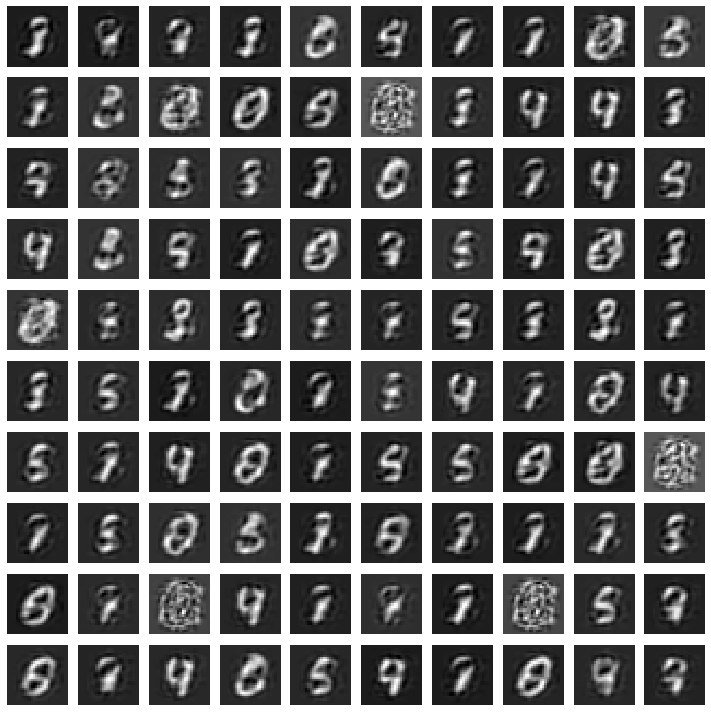

In [0]:
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)